<a href="https://colab.research.google.com/github/MeredithGao/ML-23/blob/main/HW4/NLI_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4: Lab (20 points)

## Name: Wenxuan Lu (wlu15), Zhenhan Gan (zgan4), Mingtian Gao (mgao32)

Please refer to the PDF description for homework 4 for a detailed description of this notebook and the goals of this assignment.

You will hand in a PDF of this notebook. Please be sure to clearly answer each question listed in the homework PDF.

## Setup the code.

In [186]:
# Turn on GPU backend for this Colab by clicking `Runtime > Change Runtime Type` above.

!pip install torch==1.10.0
!pip install torchtext==0.6.0

import torch
import torchtext
import torchtext.data as data
from torchtext.vocab import Vectors, GloVe
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Define the Neural Network 

In [258]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim, dropout):
        super(MLP, self).__init__()
        self.l1 = torch.nn.Linear(input_dim, output_dim) 
        self.l2 = torch.nn.Linear(output_dim, output_dim) 
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        x = self.l1(x).relu()
        x = self.dropout(x)
        x = self.l2(x).relu()
        x = self.dropout(x)
        return x

class AttentionModel(torch.nn.Module):
    def __init__(self,
                 TEXT, LABEL,
                 hidden_attn, hidden_aligned, hidden_final,
                 dropout = 0.2, device = 'cpu', freeze_emb = True):
        super().__init__()
        # record parameters
        self.device = device
        self.dropout = dropout

        # initialize embedding
        self.pretrained_emb = TEXT.vocab.vectors.to(device)
        self.embedding = (
            torch.nn.Embedding.from_pretrained(self.pretrained_emb, freeze=freeze_emb)       
                ) # seqlen x embedding
        self.embedding.weight[1] = torch.zeros(300)
        self.embedding_projection = torch.nn.Linear(self.pretrained_emb.shape[1], 200) # embedding x embedding
        emb_dim = 200

        # initialize feedforward modules
        self.feedforward_attn = MLP(emb_dim, hidden_attn, self.dropout) # 'embedding', 'hidden',
        self.feedforward_aligned = MLP(2*emb_dim, hidden_aligned, self.dropout)
        self.feedforward_agg = MLP(2*hidden_aligned, hidden_final, self.dropout)
        self.final_linear = torch.nn.Linear(hidden_final, len(LABEL.vocab))
        self.to(device)

    def forward(self, premise, hypothesis):
        premise = self.embedding(premise)
        premise = self.embedding_projection(premise) #.rename('seqlen', 'seqlenPremise')
        hypothesis = self.embedding(hypothesis)
        hypothesis = self.embedding_projection(hypothesis) #.rename('seqlen', 'seqlenHypo')

        premise_mask = (premise != 0).float()
        hypothesis_mask = (hypothesis != 0).float()

        #attend
        premise_hidden = self.feedforward_attn(premise)
        hypothesis_hidden = self.feedforward_attn(hypothesis)
        
        # matmul: [B, L1, D] * [B, D, L2] -> [B, L1, L2]
        # hypothesis_hidden: L1, B, D
        # premise_hidden: L2, B, D
        hypothesis_hidden = hypothesis_hidden.permute((1,0,2))
        premise_hidden = premise_hidden.permute((1,2,0))
        self.attn = torch.matmul(hypothesis_hidden, premise_hidden)
        #self.attn = premise_hidden.dot(hypothesis_hidden)
        # attn.shape: B, L1, L2
        self.attn_beta = self.attn.softmax(2)
        # premise: L2, B, D -> B, L2, D
        # beta: B, L1, D
        beta = torch.matmul(self.attn_beta, premise.permute((1,0,2)))
        
        # hypothesis: L1, B, D -> B, L1, D
        # attn: B, L1, L2 -> B, L2, L1
        # alpha: B, L2, D
        self.attn_alpha = self.attn.softmax(1).permute((0,2,1))
        alpha = torch.matmul(self.attn_alpha, hypothesis.permute((1, 0, 2)))

        #hypothesis_mask: L1, B, D
        # premise_mask: L2, B, D
        beta = beta.permute((1, 0, 2)) * hypothesis_mask 
        alpha = alpha.permute((1, 0, 2)) * premise_mask 

        #compare
        hypothesis_comparison = self.feedforward_aligned(torch.cat([beta, hypothesis], dim=2)).sum(dim=0) # sum along L1
        premise_comparison = self.feedforward_aligned(torch.cat([alpha, premise], dim=2)).sum(dim=0) # sum along L2
        # B, D

        #aggregate
        agg = torch.cat([premise_comparison, hypothesis_comparison], dim=1) # cat along , 'hidden'
        agg = self.feedforward_agg(agg)
        agg = self.final_linear(agg)
        return agg, self.attn

    def fit(self, train_iter, val_iter=[], lr=0.0001, verbose=True,
            batch_size=128, epochs=100, interval=500):
        self.to(self.device)
        lr = torch.tensor(lr)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        train_iter.batch_size = batch_size
        pre = []
        hypo = []
        labs = []
        true_labels = []


        for epoch in range(epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            self.train()
            
            for i, data in enumerate(train_iter, 0):
                premise, hypothesis, labels = (
                    data.premise,
                    data.hypothesis,
                    data.label
                )
                if epoch == 0 and i==500:
                  for premise_ids in premise.permute((1,0)):
                    pre.append(vocab_id_to_string(premise_ids.tolist(), TEXT))
                  for hypothesis_ids in hypothesis.permute((1,0)):
                    hypo.append(vocab_id_to_string(hypothesis_ids.tolist(), TEXT))
                  labs += labels.tolist()
                  true_labels = [vocab_id_to_string(l, LABEL) for l in labs]
            

                # forward + backward + optimize
                outputs, _ = self(premise, hypothesis)
                loss = criterion(
                    outputs,
                    labels,
                )
                # zero the parameter gradients
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % interval == 0 and i > 0 and verbose:
                    print(f"batch: {i}, loss: {running_loss/interval}")
                    running_loss = 0
            if verbose and val_iter is not None:
                val_loss = self.validate(val_iter)
                print(f"epoch: {epoch}, val loss: {val_loss}")
        return pre, hypo, true_labels
        
    def validate(self, val_iter):
        running_loss = 0
        val_count = 0
        self.eval()
        criterion = torch.nn.CrossEntropyLoss()

        for i, data in enumerate(val_iter):
            premise, hypothesis, labels = (
                data.premise,
                data.hypothesis,
                data.label
            )

            outputs, _ = self(premise, hypothesis)
            loss = criterion(
                outputs,
                labels
            )
            running_loss += loss.item()
            val_count += 1
        avg_loss = running_loss / val_count
        return avg_loss

## Load the data

In [188]:
# The data
# Our input x
TEXT = data.Field()

# Our labels y
LABEL = data.Field(sequential=False,)

train, val, test = torchtext.datasets.SNLI.splits(
    TEXT, LABEL)

pretrained_embedding = 'glove.6B.300d'
embedding_dim = 300
embedding_num = 100


TEXT.build_vocab(train)
LABEL.build_vocab(train)

train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
    (train, val, test), batch_size=128, device=torch.device("cuda"), repeat=False, shuffle=False) # cpu

# Assign word embeddings.
# Out-of-vocabulary (OOV) words are hashed to one of 100 random embeddings. 
# Initialized to mean 0 and standarad deviation 1.  

unk_vectors = [torch.randn(embedding_dim) for _ in range(embedding_num)]
TEXT.vocab.load_vectors(vectors=pretrained_embedding, unk_init=lambda x:random.choice(unk_vectors))

# Normalize s.t. l_2 norm = 1. 

vectors = TEXT.vocab.vectors
vectors = vectors / vectors.norm(dim=1,keepdim=True)
vectors = torch.tensor(vectors) # dims: word, embedding 
TEXT.vocab.vectors = vectors

# Helper function that converts vocabulary ids to string
def vocab_id_to_string(ids, FIELD):
    string = ""
    if type(ids) == list:
        for id in ids:
            if id != 1: # remove <pad>
                string += " " + FIELD.vocab.itos[id]
    elif type(ids) == int:
        string = FIELD.vocab.itos[ids]
    return string

# Helper function that converts string to vocabulary ids
def string_to_vocab_ids(string):
    vocab_ids = []
    for w in string.strip().split():
        vocab_ids.append(TEXT.vocab.stoi[w])
    return vocab_ids

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Train the Model

Train the model on the training set and save the checkpoint.

In [259]:
def train(model_ckpt, epoch=1):
    model = AttentionModel(TEXT=TEXT, LABEL=LABEL, hidden_attn=200, hidden_aligned=200, hidden_final=200, device=torch.device("cuda"))
    pre, hypo, true_labels = model.fit(train_iter, val_iter, epochs=epoch)
    torch.save(model.state_dict(), model_ckpt)
    return pre, hypo, true_labels

#Evaluate on Test Set

Given a checkpoint, this function would report the accuracy on test set and generate an output file **predictions.txt** which contains information including *sample id*, *premise*, *hypothesis*, *predicted label*, *true label*.

In [190]:
def test_model(model_ckpt):
    with torch.no_grad():
        model = AttentionModel(TEXT=TEXT, LABEL=LABEL, hidden_attn=200, hidden_aligned=200, hidden_final=200, device=torch.device("cuda"))
        model.load_state_dict(torch.load(model_ckpt))
        result = []
        labels = []

        predictions = []
        true_labels = []
        premises = []
        hypothesis = []
        
        test_iter = torchtext.data.BucketIterator(test, train=False, batch_size=10, device=torch.device("cuda"))
        for batch in test_iter:
            # batch.premise: L2, B
            for premise_ids in batch.premise.permute((1,0)):
                premises.append(vocab_id_to_string(premise_ids.tolist(), TEXT))
            for hypothesis_ids in batch.hypothesis.permute((1,0)):
                hypothesis.append(vocab_id_to_string(hypothesis_ids.tolist(), TEXT))
                
            probs, _ = model(batch.premise, batch.hypothesis)
            _, amax = probs.max(dim=1)
            result += amax.tolist()
            labels += batch.label.tolist()

            predictions = [vocab_id_to_string(r, LABEL) for r in result]
            true_labels = [vocab_id_to_string(l, LABEL) for l in labels]
            
        with open("predictions.txt", "w") as f:
           f.write("Id,Premise,Hypothesis,Prediction,True Label\n")
           for i in range(len(result)):
               f.write(str(i) + "," + premises[i] + "," + hypothesis[i] + "," + predictions[i] + "," + true_labels[i] + "\n")
        
        acc = sum(result[i] == labels[i] for i in range(len(result)))
        print("Accuracy on test set: %.2f" % ((acc / len(result))*100) + "%.")

# Get Attention Weights

Load a checkpoint, evaluate on a sample and get the attention weights.

In [191]:
#We add a get_prediction to get the predicted label for our examples

def get_prediction(model_ckpt, premise, hypothesis):
    # Arguments:
    #   model_ckpt: the model checkpoint *.pt file
    #   premise: a Python string
    #   hypothesis: a Python string
    # Output:
    #   prediction
    with torch.no_grad():
        result = []
        predictions = []
        model = AttentionModel(TEXT=TEXT, LABEL=LABEL, hidden_attn=200, hidden_aligned=200, hidden_final=200, device=torch.device("cuda"))
        model.load_state_dict(torch.load(model_ckpt))
        premise = string_to_vocab_ids(premise)
        hypothesis = string_to_vocab_ids(hypothesis)
        premise = torch.tensor(premise).reshape((-1,1)).to("cuda")
        hypothesis = torch.tensor(hypothesis).reshape((-1,1)).to("cuda")
        probs, _ = model(premise, hypothesis)
        _, amax = probs.max(dim=1)
        result += amax.tolist()
        prediction = [vocab_id_to_string(r, LABEL) for r in result]
            
    return prediction

In [224]:
def get_attentions(model_ckpt, premise, hypothesis):
    # Arguments:
    #   model_ckpt: the model checkpoint *.pt file
    #   premise: a Python string
    #   hypothesis: a Python string
    # Output:
    #   Tensor in the shape of (length_hypothesis, length_premise)
    with torch.no_grad():
        result = []
        prediction = []
        model = AttentionModel(TEXT=TEXT, LABEL=LABEL, hidden_attn=200, hidden_aligned=200, hidden_final=200, device=torch.device("cuda"))
        model.load_state_dict(torch.load(model_ckpt))
        premise = string_to_vocab_ids(premise)
        hypothesis = string_to_vocab_ids(hypothesis)
        premise = torch.tensor(premise).reshape((-1,1)).to("cuda")
        hypothesis = torch.tensor(hypothesis).reshape((-1,1)).to("cuda")
        probs, attn = model(premise, hypothesis)
        _, amax = probs.max(dim=1)
        result += amax.tolist()
        prediction = [vocab_id_to_string(r, LABEL) for r in result]
        #print(prediction[0])
    return attn.squeeze(0).to('cpu') 

# Visualize the Attention Weights

In [225]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_token2head_scores(scores, premise, hypothesis):
    premise = premise.split()
    hypothesis = hypothesis.split()
    fig = plt.figure(figsize=(30, 50))

    scores_np = np.array(scores)
    ax = fig.add_subplot(6, 2, 1)
    # append the attention weights
    im = ax.matshow(scores_np, cmap='viridis')

    fontdict = {'fontsize': 20}

    ax.set_xticks(range(len(premise)))
    ax.set_yticks(range(len(hypothesis)))

    ax.set_xticklabels(premise, fontdict=fontdict, rotation=90)
    ax.set_yticklabels(hypothesis, fontdict=fontdict)

    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Example

1. Load a pretrained checkpoint and report the accuracy.

In [194]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [208]:
# train("ckpt3.pt", epoch=3) You can train your own model using this line of code.
test_model("/content/gdrive/MyDrive/ckpt20.pt") # We have provided you with this checkpoint. You can upload it to the "content" directory.
# We trained the model for 20 epochs with the given hyperparameters to get this checkpoint.

Accuracy on test set: 72.53%.


Assuming everything went well, you should have an accuray on the test set of around 72.78%. The splits might vary on differnt machines thus the accuracy on test set might also vary.

2. The first step generated a file "predictions.txt". We can pick a sample from the file for further analysis. Here, we decided to pick the following sample:

```
Id, Premise,        Hypothesis,                Prediction,    True Label
0,  A biker races., The biker loses the race,  contradiction, neutral
```

3. Extract the attention weights.

In [196]:
premise = "A biker races."
hypothesis = "The biker loses the race"
scores = get_attentions("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)

4. Visualize the attention weights.

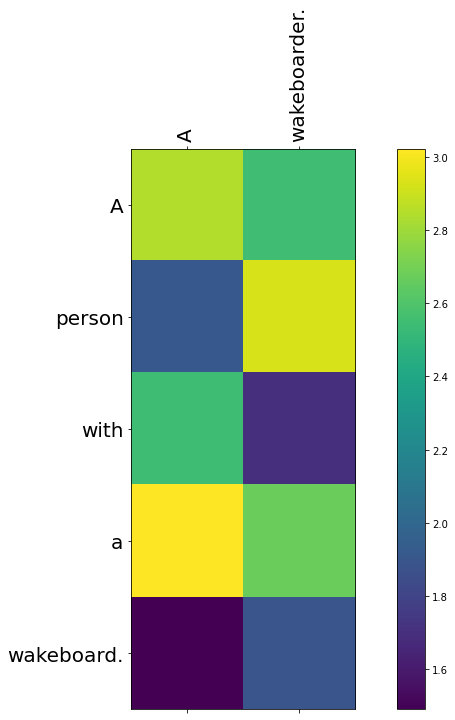

In [226]:
visualize_token2head_scores(scores, premise, hypothesis)

## Answers
In the following section, you will answer questions about the trained model on the learned attention weights.

You will answer each of the following questions in the notebook. In each question, you will draw a figure that shows the attention weights $e_{ij}$.

In each questions, your figure will be a matrix, where an entry for the $i$th row and $j$th column will visualize the weight $e_{ij}$. Darker values mean larger numbers.

Q1.1 (4 points): Draw a figure that shows the attention weights for a correctly classified example from test set for the entailment, contradiction and the neutral classes, respectively. Explain how the learned attention weights contribute to the correct predictions.


**entailment**
```
Id, Premise,        Hypothesis,                Prediction,    True Label
3, A wakeboarder., A person with a wakeboard.,entailment,entailment
```

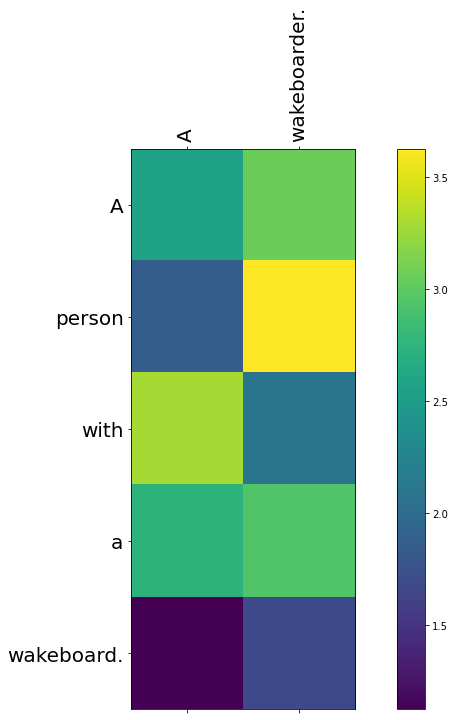

In [227]:
premise = "A wakeboarder."
hypothesis = "A person with a wakeboard."
scores = get_attentions("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)
visualize_token2head_scores(scores, premise, hypothesis)


**contradiction**
```
Id, Premise,        Hypothesis,                Prediction,    True Label
1, A dog runs., The dog is walking,contradiction,contradiction
```

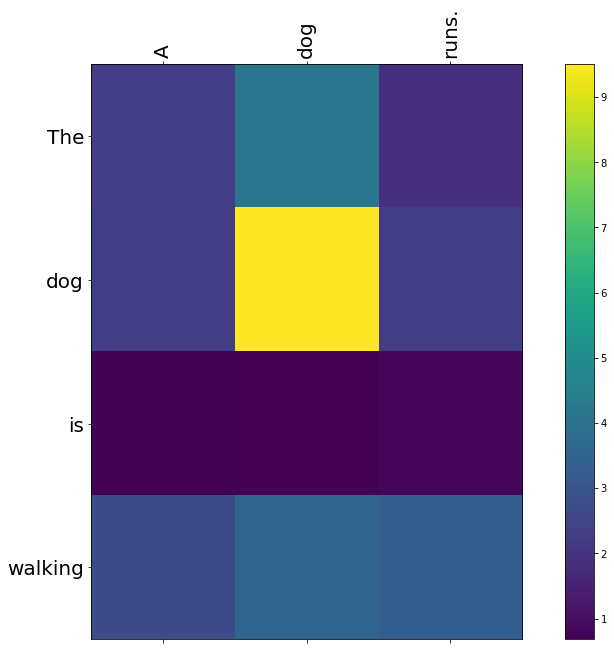

In [264]:
premise = "A dog runs."
hypothesis = "The dog is walking"
scores = get_attentions("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)
visualize_token2head_scores(scores, premise, hypothesis)



**neutral**
```
136, Man walking a small pug., The man is a mailman.,neutral,neutral
```

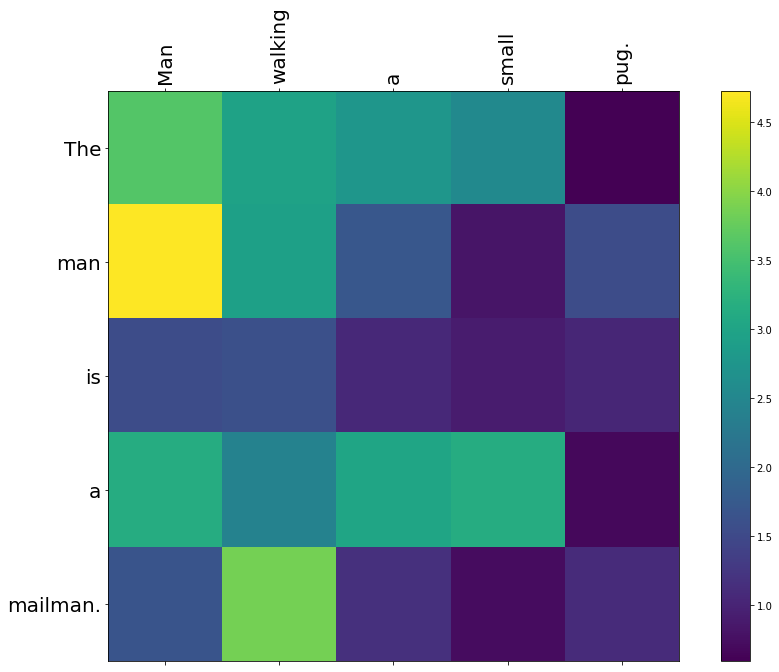

In [229]:
premise = "Man walking a small pug." 
hypothesis = "The man is a mailman."
scores = get_attentions("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)
visualize_token2head_scores(scores, premise, hypothesis)

TODO:

*   For correctly labeled entailment example, the 
biggest weight is at "wakeboarder" and "person", indicating that this combination contributes the most to the correst prediction, which is plausible because the significant point in this prediction is that wakeboarder means a person with a wakeboard.
*   For contradiction, "dog" and "dog", "runs" and "walking" have the biggest weights. These are the significant points for this example to have a correct prediction because the same subject cannot be followed by two different verbs.

*   For neutral example, "Man" and "man", "The" and "man", "walking" and "mailman" have the biggest weights. For the same subject, "walking" and "mailman" have no contradictive or entailed relation, thus the neutral prediction is correct.


We can see that for correctly predicted examples, models can precisely find the subjects, verbs, or adjectives that are significant for determining which relation premise and hypothesis have.

Q1.2 (4 points): Draw a figure that shows the attention weights for an incorrectly classified example from test set for the entailment, contradiction and the neutral classes, respectively.

Describe the difference between the pattern in these attention weights with those of the correctly predicted examples above.


**entailment**
```
Id, Premise,        Hypothesis,                Prediction,    True Label
13, A biker races., A person is riding a bike,contradiction,entailment
```

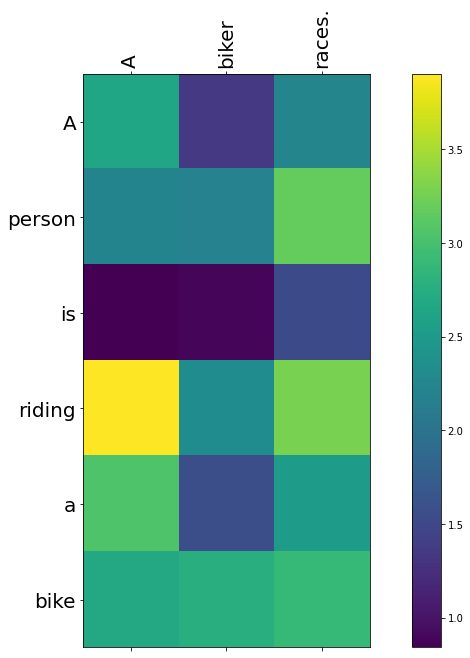

In [231]:
premise = "A biker races." 
hypothesis = "A person is riding a bike"
scores = get_attentions("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)
visualize_token2head_scores(scores, premise, hypothesis)

**contradiction**
```
Id, Premise,        Hypothesis,                Prediction,    True Label
9, Men play hockey., Aliens play,neutral,contradiction
```

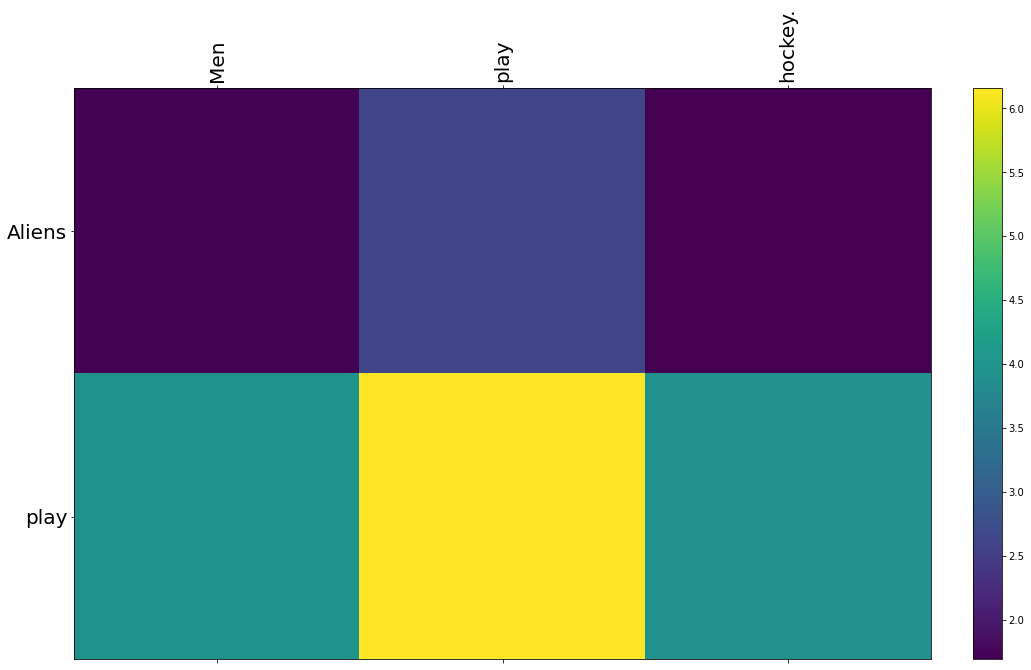

In [233]:
premise = "Men play hockey." 
hypothesis = "Aliens play"
scores = get_attentions("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)
visualize_token2head_scores(scores, premise, hypothesis)

**neutral**
```
Id, Premise,        Hypothesis,                Prediction,    True Label
107, Times Square in New York., Times Square is packed.,entailment,neutral
```

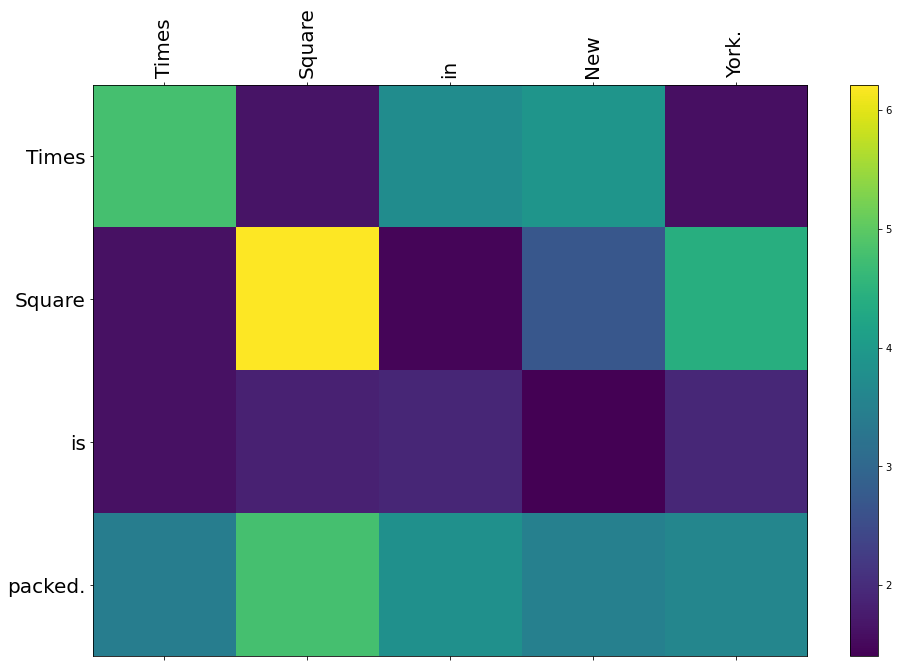

In [239]:
premise = "Times Square in New York." 
hypothesis = "Times Square is packed."
scores = get_attentions("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)
visualize_token2head_scores(scores, premise, hypothesis)

TODO:

*  For entailment, the model puts more weights on "A" and "riding" and "races" and "riding" while it should focus more on "biker" and "riding" or "biker" and "bike".
*   For contradiction, the model puts the most weight on "play" and "play", but it should focus more on "Men" and "Aliens".
*   For neutral, the model puts the most weights on "Square" and "Square", "Square" and "packed", "Times" and "Times", and incorrectly output that they have entailed relation.


For incorrectly predicted examples, the model fails to find the combination of words that is significant for prediction.







Q2.1 (2 points): Write your own example of an NLI instance (hypothesis and premise)
such that the label is ambiguous (i.e. write a confusing/hard example!). Draw a figure of
the attention weights and explain how the model’s uncertainty is reflected in the weights.

```
Premise,        Hypothesis,     True Label
He always studied the book before., The man did previews., neutral
```

Prediction: contradiction


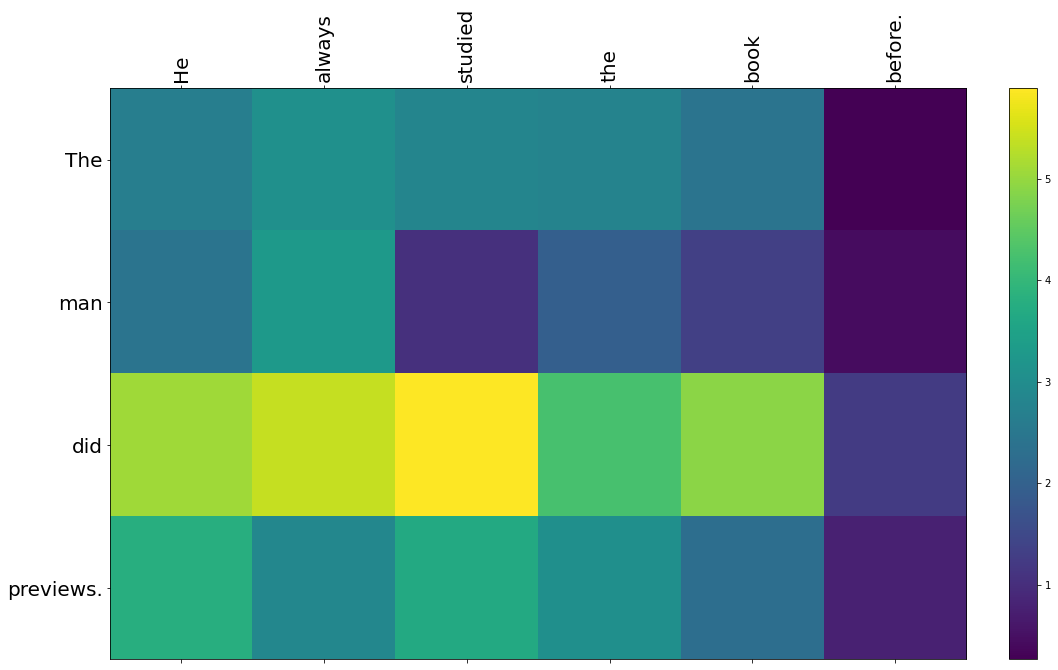

In [240]:
premise = "He always studied the book before." 
hypothesis = "The man did previews."
print("Prediction:", get_prediction("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)[0])
scores = get_attentions("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)
visualize_token2head_scores(scores, premise, hypothesis)

TODO:
We can see that almost half of the word combinations has a weight higher than the average, which is reasonable because uncertainty causes the machine to consider more combinations of words to be significant in deciding the relation between the premise and hypothesis.

Q2.2 (3 points): Make up two examples yourself, such that the two examples have
similar words (but need not be identical) but the word order makes a difference in the
label. Show the attention weights for each case. Compare the weights in each case and
explain how they contribute to the model predictions.

```
Premise,        Hypothesis,     True Label
He went to see., The man saw., entailment
```

Prediction: contradiction


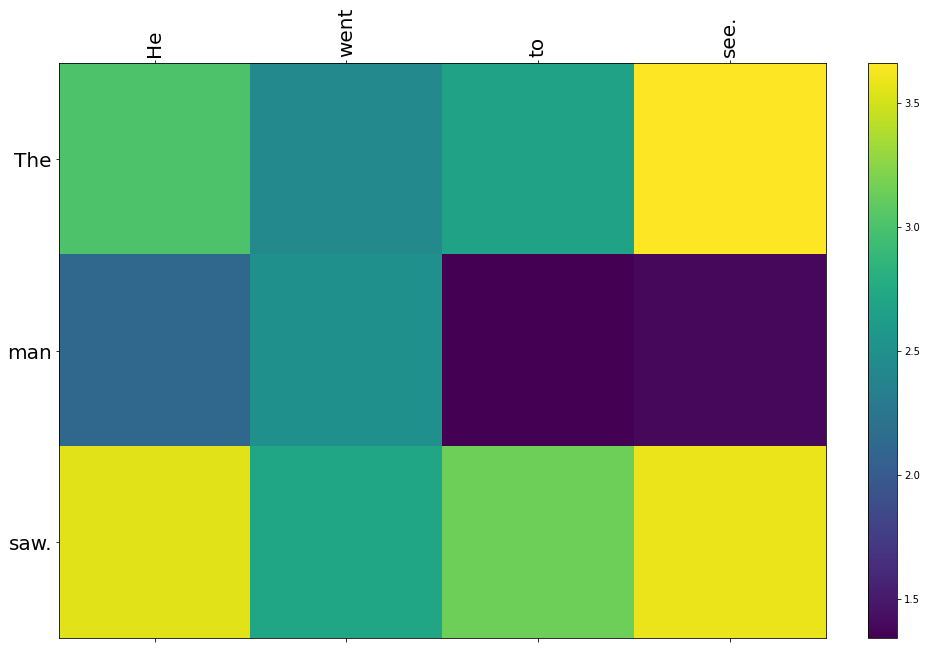

In [241]:
premise = "He went to see." 
hypothesis = "The man saw."
print("Prediction:", get_prediction("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)[0])
scores = get_attentions("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)
visualize_token2head_scores(scores, premise, hypothesis)

```
Premise,        Hypothesis,     True Label
He was witnessed going, The man saw., neutral
```

Prediction: contradiction


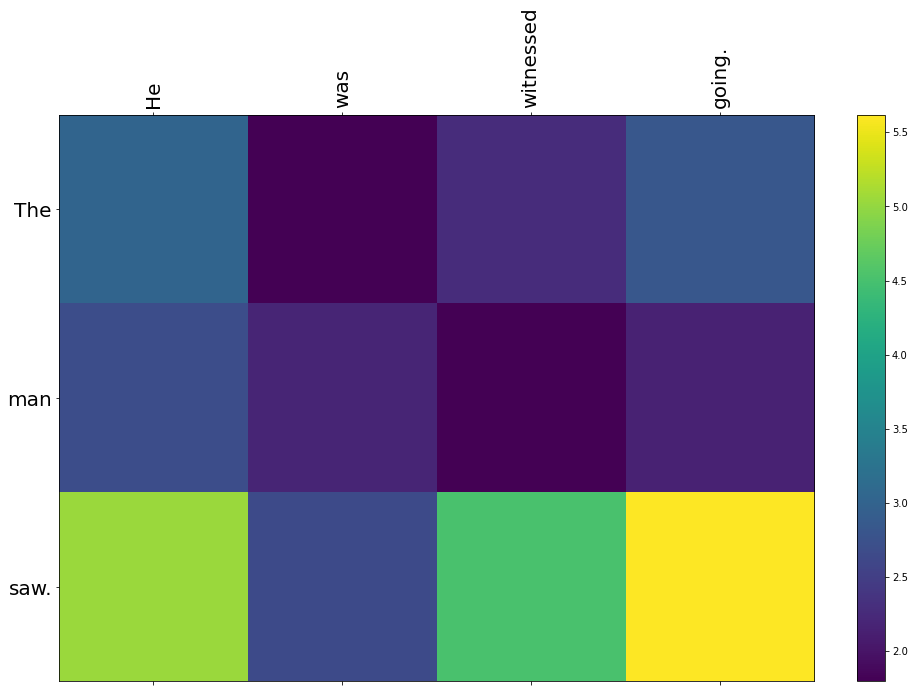

In [242]:
premise = "He was witnessed going." 
hypothesis = "The man saw."
print("Prediction:", get_prediction("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)[0])
scores = get_attentions("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)
visualize_token2head_scores(scores, premise, hypothesis)

TODO: In the former example, highest weights are put at "He" and "saw", as well as "see" and "saw", "to" and "saw" whereas in the latter example, the highest is at "going" and "saw", "He" and "saw". The change in word order causes the model to focus on different combinations of words. Here we changed the order of "went/going" and "see/witnessed" in the premise sentences with hypothesis unchanged, so that we changed the significant points to determine the prediction. The model adapts well to this example, it put weights on "see" and "saw" in the first example but put weights on "going" and "saw" in the second example instead of "witnessed" and "saw".

Q3.1 (7 points): Randomly initialize the model and start training from scratch. Train
for 3 epochs. On a fast GPU, this will be 1 minute per epoch, but it may be slower on
older GPUs. Select an example from the training set and plot the attention weights of the
model after the third epoch versus those of the fully trained model. Draw a figure of each
of the attention weights and describe the difference.

In [260]:
pre, hypo, true_labels = train("ckpt3.pt", epoch=3)

batch: 500, loss: 1.085152617931366
batch: 1000, loss: 1.0017480759620667
batch: 1500, loss: 0.9575727369785308
batch: 2000, loss: 0.9424737205505371
batch: 2500, loss: 0.9336189042329788
batch: 3000, loss: 0.927016235947609
batch: 3500, loss: 0.9225663571357727
batch: 4000, loss: 0.9145926488637924
epoch: 0, val loss: 0.9275315961280426
batch: 500, loss: 0.9119501093626022
batch: 1000, loss: 0.9056760100126267
batch: 1500, loss: 0.9007017186880112
batch: 2000, loss: 0.9015420235395432
batch: 2500, loss: 0.8948997777700424
batch: 3000, loss: 0.8896437711715698
batch: 3500, loss: 0.8876000144481659
batch: 4000, loss: 0.878269051194191
epoch: 1, val loss: 0.880362360508411
batch: 500, loss: 0.8766445044279099
batch: 1000, loss: 0.8678416261672973
batch: 1500, loss: 0.8643314611911773
batch: 2000, loss: 0.8615302064418793
batch: 2500, loss: 0.8583296874761581
batch: 3000, loss: 0.8529194166660309
batch: 3500, loss: 0.8512221426963806
batch: 4000, loss: 0.8433645125627518
epoch: 2, val los

```
Premise,        Hypothesis,        True Label
A young boy is playing the trumpet at a concert., A young boy is playing an instrument., entailment
```

['entailment']


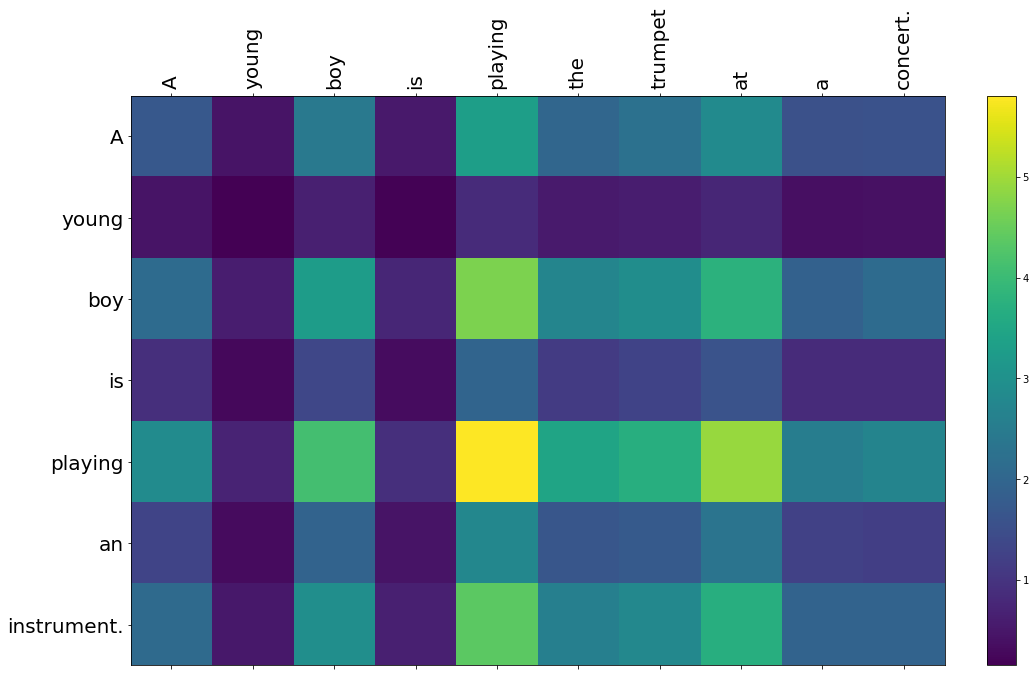

In [312]:
#Model after the third epoch
premise = "A young boy is playing the trumpet at a concert." 
hypothesis = "A young boy is playing an instrument."
print(get_prediction("ckpt3.pt", premise, hypothesis))
scores = get_attentions("ckpt3.pt", premise, hypothesis)
visualize_token2head_scores(scores, premise, hypothesis)

['entailment']


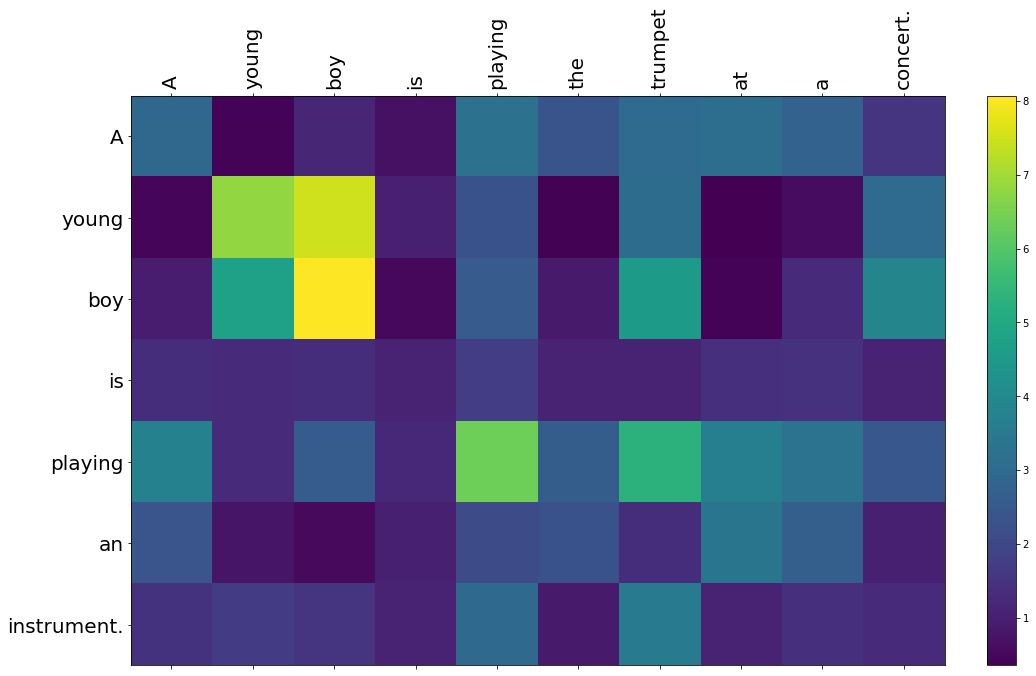

In [313]:
#Fully trained model
premise = "A young boy is playing the trumpet at a concert." 
hypothesis = "A young boy is playing an instrument."
print(get_prediction("ckpt3.pt", premise, hypothesis))
scores = get_attentions("/content/gdrive/MyDrive/ckpt20.pt", premise, hypothesis)
visualize_token2head_scores(scores, premise, hypothesis)

TODO: In the graph of fully trained model, we have fewer high weights distributed which are mainly at the combinations of words "young", "boy", "playing", "trumpet". This tells us that fully trained model is more aware of which words play an important role in deciding the relation between premise and hypothesis than the 3-epoch trained model.

# You're Done!

You are finished. Print this notebook to a PDF and submit.